<a href="https://colab.research.google.com/github/Suchith-nj/Projects/blob/main/Image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required packages
!pip install -q datasets transformers accelerate evaluate pillow

# Complete Food-101 Training - Single Cell

# 1. Setup
from google.colab import userdata
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoImageProcessor,
    AutoModelForImageClassification,
    TrainingArguments,
    Trainer
)
import evaluate
import numpy as np

# Setup HF token
hf_token = userdata.get('HF_TOKEN')
os.environ['HF_TOKEN'] = hf_token

# Check GPU
print(f"GPU Available: {torch.cuda.is_available()}")
print(f"GPU Name: {torch.cuda.get_device_name(0)}\n")

# 2. Load Dataset
print("Loading Food-101 dataset...")
dataset = load_dataset("food101")
print(f"Train samples: {len(dataset['train']):,}")
print(f"Test samples: {len(dataset['validation']):,}\n")

# Get class names
class_names = dataset['train'].features['label'].names
print(f"Number of classes: {len(class_names)}\n")

# 3. Setup Preprocessing
model_name = "microsoft/resnet-50"
processor = AutoImageProcessor.from_pretrained(model_name)

def preprocess_dataset(example):
    image = example['image'].convert("RGB")
    inputs = processor(image, return_tensors="pt")
    return {
        'pixel_values': inputs['pixel_values'].squeeze(0),
        'labels': example['label']
    }

# 4. Split and Preprocess Data
print("Splitting dataset...")
train_val = dataset['train'].train_test_split(test_size=0.1, seed=42)

print("Preprocessing train dataset (this takes 5-10 minutes)...")
train_dataset = train_val['train'].map(
    preprocess_dataset,
    remove_columns=['image', 'label'],
    batched=False
)

print("Preprocessing validation dataset...")
val_dataset = train_val['test'].map(
    preprocess_dataset,
    remove_columns=['image', 'label'],
    batched=False
)

print("Preprocessing test dataset...")
test_dataset = dataset['validation'].map(
    preprocess_dataset,
    remove_columns=['image', 'label'],
    batched=False
)

# Set format
train_dataset.set_format(type='torch', columns=['pixel_values', 'labels'])
val_dataset.set_format(type='torch', columns=['pixel_values', 'labels'])
test_dataset.set_format(type='torch', columns=['pixel_values', 'labels'])

print(f"\nTrain: {len(train_dataset):,}")
print(f"Validation: {len(val_dataset):,}")
print(f"Test: {len(test_dataset):,}\n")

# 5. Load Model
print("Loading model...")
id2label = {i: label for i, label in enumerate(class_names)}
label2id = {label: i for i, label in enumerate(class_names)}

model = AutoModelForImageClassification.from_pretrained(
    model_name,
    num_labels=len(class_names),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

print(f"Model loaded: {model_name}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}\n")

# 6. Setup Metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='weighted')

    return {
        'accuracy': accuracy['accuracy'],
        'f1': f1['f1']
    }

# 7. Training Arguments
training_args = TrainingArguments(
    output_dir="./food101-resnet50",
    num_train_epochs=5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_steps=500,
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    fp16=True,
    dataloader_num_workers=0,
    push_to_hub=True,
    hub_model_id="suchithnj12/food101-resnet50",
    hub_strategy="end",
    report_to="none"
)

# 8. Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# 9. Train
print("Starting training (this takes 2-3 hours)...")
print("-" * 60)
train_result = trainer.train()

print("\nTraining completed!")
print(f"Final train loss: {train_result.metrics['train_loss']:.4f}")
print(f"Training time: {train_result.metrics['train_runtime']/60:.2f} minutes\n")

# 10. Evaluate on Test Set
print("Evaluating on test set...")
test_results = trainer.evaluate(test_dataset)

print("\nTest Results:")
print(f"Accuracy: {test_results['eval_accuracy']:.4f}")
print(f"F1 Score: {test_results['eval_f1']:.4f}\n")

# 11. Push to Hub
print("Pushing model to HuggingFace Hub...")
trainer.push_to_hub(commit_message="Food-101 ResNet-50 trained model")

print(f"\nModel available at: https://huggingface.co/suchithnj12/food101-resnet50")
print("Training pipeline completed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.8 MB/s eta 0:00:00
GPU Available: True
GPU Name: Tesla T4

Loading Food-101 dataset...


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00008.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

data/train-00001-of-00008.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

data/train-00002-of-00008.parquet:   0%|          | 0.00/472M [00:00<?, ?B/s]

data/train-00003-of-00008.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

data/train-00004-of-00008.parquet:   0%|          | 0.00/475M [00:00<?, ?B/s]

data/train-00005-of-00008.parquet:   0%|          | 0.00/470M [00:00<?, ?B/s]

data/train-00006-of-00008.parquet:   0%|          | 0.00/478M [00:00<?, ?B/s]

data/train-00007-of-00008.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

data/validation-00000-of-00003.parquet:   0%|          | 0.00/423M [00:00<?, ?B/s]

data/validation-00001-of-00003.parquet:   0%|          | 0.00/413M [00:00<?, ?B/s]

data/validation-00002-of-00003.parquet:   0%|          | 0.00/426M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]

Train samples: 75,750
Test samples: 25,250

Number of classes: 101

Splitting dataset...
Preprocessing train dataset (this takes 5-10 minutes)...


Map:   0%|          | 0/68175 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Preprocessing validation dataset...


Map:   0%|          | 0/7575 [00:00<?, ? examples/s]

Preprocessing test dataset...


Map:   0%|          | 0/25250 [00:00<?, ? examples/s]


Train: 68,175
Validation: 7,575
Test: 25,250

Loading model...


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([101, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded: microsoft/resnet-50
Total parameters: 23,714,981



Starting training (this takes 2-3 hours)...
------------------------------------------------------------


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,4.496600,4.458635,0.166337,0.154736
2,3.814000,3.742320,0.298614,0.261986
3,3.257200,3.191649,0.362508,0.330396
4,2.935900,2.900200,0.397096,0.368665
5,2.847600,2.818526,0.408317,0.380199



Training completed!
Final train loss: 3.6109
Training time: 116.77 minutes

Evaluating on test set...



Test Results:
Accuracy: 0.4450
F1 Score: 0.4139

Pushing model to HuggingFace Hub...


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...esnet50/model.safetensors:   0%|          | 26.5kB / 95.1MB            

  ...esnet50/training_args.bin:   2%|2         |   117B / 5.84kB            


Model available at: https://huggingface.co/suchithnj12/food101-resnet50
Training pipeline completed successfully!


In [ ]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np

# Load Food-101 (will download ~5GB)
print("Loading Food-101 dataset...")
dataset = load_dataset("food101")

print(f"Train samples: {len(dataset['train'])}")
print(f"Test samples: {len(dataset['validation'])}")

# Get class names
labels = dataset['train'].features['label']
class_names = labels.names
print(f"Number of classes: {len(class_names)}")
print(f"Sample classes: {class_names[:10]}")

Loading Food-101 dataset...


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00008.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

data/train-00001-of-00008.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

data/train-00002-of-00008.parquet:   0%|          | 0.00/472M [00:00<?, ?B/s]

data/train-00003-of-00008.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

data/train-00004-of-00008.parquet:   0%|          | 0.00/475M [00:00<?, ?B/s]

data/train-00005-of-00008.parquet:   0%|          | 0.00/470M [00:00<?, ?B/s]

data/train-00006-of-00008.parquet:   0%|          | 0.00/478M [00:00<?, ?B/s]

data/train-00007-of-00008.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

data/validation-00000-of-00003.parquet:   0%|          | 0.00/423M [00:00<?, ?B/s]

data/validation-00001-of-00003.parquet:   0%|          | 0.00/413M [00:00<?, ?B/s]

data/validation-00002-of-00003.parquet:   0%|          | 0.00/426M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]

Train samples: 75750
Test samples: 25250
Number of classes: 101
Sample classes: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']


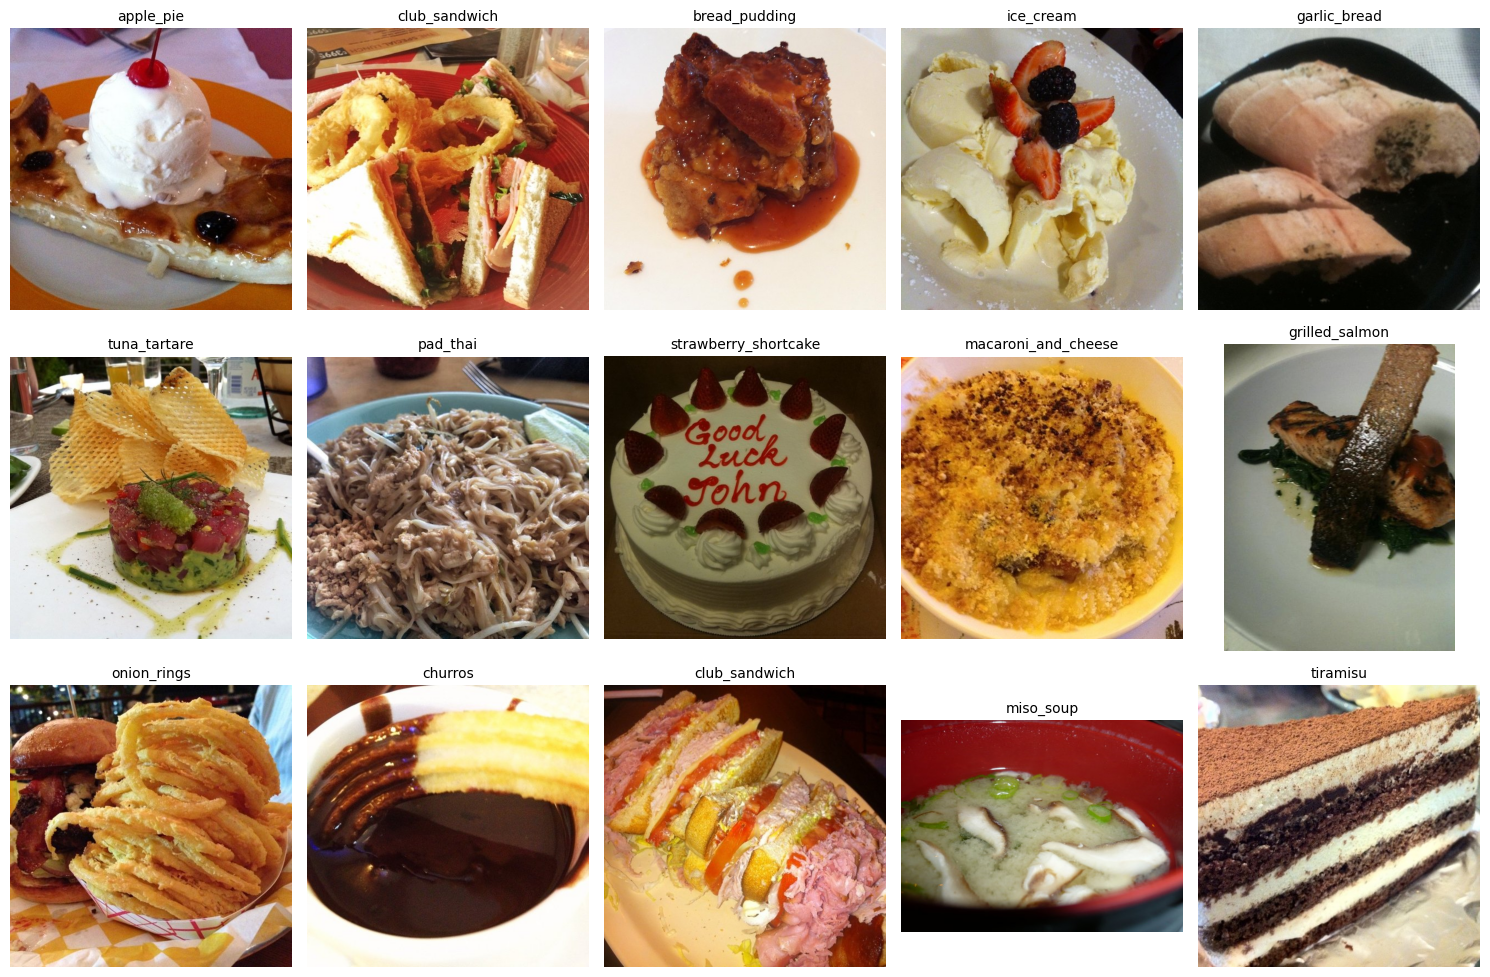

In [ ]:
# Visualize random samples
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 5, figsize=(15, 10))
axes = axes.flatten()

for i in range(15):
    idx = np.random.randint(0, len(dataset['train']))
    sample = dataset['train'][idx]

    axes[i].imshow(sample['image'])
    axes[i].set_title(class_names[sample['label']], fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from transformers import AutoImageProcessor
import torch

model_name = "microsoft/resnet-50"
processor = AutoImageProcessor.from_pretrained(model_name)

# Function to preprocess entire dataset (not batched)
def preprocess_dataset(example):
    image = example['image'].convert("RGB")
    inputs = processor(image, return_tensors="pt")

    # Return as dict with squeezed tensors
    return {
        'pixel_values': inputs['pixel_values'].squeeze(0),
        'labels': example['label']
    }

# Split datasets
train_val = dataset['train'].train_test_split(test_size=0.1, seed=42)

# Apply map to preprocess (this actually processes all data)
print("Preprocessing train dataset...")
train_dataset = train_val['train'].map(
    preprocess_dataset,
    remove_columns=['image', 'label'],
    batched=False
)

print("Preprocessing validation dataset...")
val_dataset = train_val['test'].map(
    preprocess_dataset,
    remove_columns=['image', 'label'],
    batched=False
)

print("Preprocessing test dataset...")
test_dataset = dataset['validation'].map(
    preprocess_dataset,
    remove_columns=['image', 'label'],
    batched=False
)

# Set format to pytorch tensors
train_dataset.set_format(type='torch', columns=['pixel_values', 'labels'])
val_dataset.set_format(type='torch', columns=['pixel_values', 'labels'])
test_dataset.set_format(type='torch', columns=['pixel_values', 'labels'])

print(f"Train: {len(train_dataset):,}")
print(f"Validation: {len(val_dataset):,}")
print(f"Test: {len(test_dataset):,}")

NameError: name 'dataset' is not defined

In [ ]:
from transformers import AutoModelForImageClassification

# Create label mappings
id2label = {i: label for i, label in enumerate(class_names)}
label2id = {label: i for i, label in enumerate(class_names)}

# Load model
model = AutoModelForImageClassification.from_pretrained(
    model_name,
    num_labels=len(class_names),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

# Move to GPU
model = model.to("cuda")

print(f"Model loaded: {model_name}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Device: {next(model.parameters()).device}")

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([101, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded: microsoft/resnet-50
Total parameters: 23,714,981
Device: cuda:0


In [ ]:
!rm -rf /content/* ~/.cache/huggingface ~/.cache/torch ~/.cache/transformers && pip cache purge -y && apt-get clean && rm -rf /var/lib/apt/lists/*



Usage:   
  pip3 cache dir
  pip3 cache info
  pip3 cache list [<pattern>] [--format=[human, abspath]]
  pip3 cache remove <pattern>
  pip3 cache purge
  

no such option: -y


In [ ]:
import os
os.kill(os.getpid(), 9)


In [ ]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         108G   40G   69G  37% /
tmpfs            64M     0   64M   0% /dev
shm             5.8G     0  5.8G   0% /dev/shm
/dev/root       2.0G  1.2G  764M  62% /usr/sbin/docker-init
tmpfs           6.4G  120K  6.4G   1% /var/colab
/dev/sda1        73G   41G   33G  56% /kaggle/input
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware


In [ ]:
from datasets import load_dataset
from transformers import (
    AutoImageProcessor,
    AutoModelForImageClassification,
    TrainingArguments,
    Trainer
)
import torch

# Load small subset for quick demo
dataset = load_dataset("food101", split="train[:1000]")  # Only 1000 images
test_dataset = load_dataset("food101", split="validation[:200]")

# Setup
processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")

def preprocess(example):
    image = example['image'].convert("RGB")
    inputs = processor(image, return_tensors="pt")
    return {
        'pixel_values': inputs['pixel_values'].squeeze(0),
        'labels': example['label']
    }

# Preprocess
dataset = dataset.map(preprocess, remove_columns=['image', 'label'], batched=False)
test_dataset = test_dataset.map(preprocess, remove_columns=['image', 'label'], batched=False)

dataset.set_format('torch', columns=['pixel_values', 'labels'])
test_dataset.set_format('torch', columns=['pixel_values', 'labels'])

# Load model
class_names = load_dataset("food101", split="train").features['label'].names
model = AutoModelForImageClassification.from_pretrained(
    "microsoft/resnet-50",
    num_labels=len(class_names),
    ignore_mismatched_sizes=True
)

# Quick training (1 epoch)
training_args = TrainingArguments(
    output_dir="./quick-food101",
    num_train_epochs=1,
    per_device_train_batch_size=32,
    push_to_hub=False,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    eval_dataset=test_dataset
)

print("Quick training (10 minutes)...")
trainer.train()

# Push
model.push_to_hub("suchithnj12/food101-resnet50")
processor.push_to_hub("suchithnj12/food101-resnet50")

print("✅ Model pushed!")

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00008.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

data/train-00001-of-00008.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

data/train-00002-of-00008.parquet:   0%|          | 0.00/472M [00:00<?, ?B/s]

data/train-00003-of-00008.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

data/train-00004-of-00008.parquet:   0%|          | 0.00/475M [00:00<?, ?B/s]

data/train-00005-of-00008.parquet:   0%|          | 0.00/470M [00:00<?, ?B/s]

data/train-00006-of-00008.parquet:   0%|          | 0.00/478M [00:00<?, ?B/s]

data/train-00007-of-00008.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

data/validation-00000-of-00003.parquet:   0%|          | 0.00/423M [00:00<?, ?B/s]

data/validation-00001-of-00003.parquet:   0%|          | 0.00/413M [00:00<?, ?B/s]

data/validation-00002-of-00003.parquet:   0%|          | 0.00/426M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]

preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([101, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Quick training (10 minutes)...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss


README.md: 0.00B [00:00, ?B/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...plmdijs/model.safetensors:   0%|          | 26.5kB / 95.1MB            

✅ Model pushed!
